## Function code as of now

In [1]:
import sys
import numpy as np
#wd = '/home/clarice/Documents/SingleCell_PseudoTime/'
#os.chdir(wd)
#sys.path.append('extras/Stabilized_ICA')
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/')
sys.path.append('/mnt/c/MyPrograms/__github/Stabilized_ICA')
sys.path.append('/mnt/c/MyPrograms/__github/scycle/')
print(sys.path)

import os
import anndata
import scanpy as sc


from scycle.preprocess import quality_control, prep_pooling
from scycle.tools import dimensionality_reduction, enrich_components, principal_circle

def renormalize_by_partition(adata_src, adata_ref, verbose = True):
    #-- Run QC
    params = adata_ref.uns['scycle']
    pp_params = params['preprocess']
    dr_params = params['dimRed']

    quality_control(adata_src,
                    min_counts = pp_params['min_counts'], 
                    max_counts = pp_params['max_counts'], 
                    max_mt_ratio = pp_params['max_mt_ratio'],
                    verbose = False)
    old_totals = adata_src.obs['total_counts']
    
    #---- Check if samples are the same
    if not np.all(adata_src.obs.index.values == adata_ref.obs.index.values):
        raise Exception ( 'adata_ref must contain cells in adata_src')
    
    #--- Apply filter
    if verbose: print('Normalizing by partition...')

    #---- Get partitions and re-noralize
    prt = adata_ref.obs['partition']
    gexp = adata_src.X
    
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    for p in range(npart):
        sidx = prt == p # sample index
        totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
        median = np.median(totals) # median counts for samples in group
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * median
        
    #---- Re-run procedure
    adata_src.X = new_gexp
    
    if verbose: print('Re-running pooling...')
    
    prep_pooling(adata_src, 
                 filter_cells = False,
                 embed_n_comps=pp_params['embed_n_comps'],
                 min_counts = pp_params['min_counts'], 
                 max_counts = pp_params['max_counts'], 
                 max_mt_ratio = pp_params['max_mt_ratio'],
                 n_neighbors = pp_params['n_neighbors'],
                 normalize_counts = False,
                 filter_var_genes = pp_params['filter_var_genes'],
                 log_transform= pp_params['log_transform'],
                 n_top_genes = pp_params['n_top_genes'],
                 verbose = False)
    
    if verbose: print('Re-running dimensionality reduction..')
    dimensionality_reduction(adata_src,
                             method = dr_params['method'],
                             n_comps = dr_params['n_comps'],
                             seed = dr_params['seed'],
                             verbose = False)
    if 'enrich_components' in params.keys():    
        if verbose: print('Re-running component enrichment...')
        enrich_components(adata_src, verbose = False)
    
    if verbose: print('Finding the principal circle...')
    principal_circle(adata_src, n_nodes = params['principal_circle']['n_nodes'], verbose = False)
    
    adata_src.obs['total_counts'] = np.sum(adata_src.X, axis = 1)
    adata_src.obs['total_counts_raw'] = old_totals

['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/home/zinovyev/anaconda3/lib/python3.7/site-packages/skdim/', '/mnt/c/MyPrograms/__github/Stabilized_ICA', '/mnt/c/MyPrograms/__github/scycle/']


/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Pipeline start

In [2]:
file = '../EwingSarcoma_Miller2020/CHLA9/CHLA9'
sces = anndata.read_loom(file+'.loom')
sces.var_names_make_unique()

#-- Hack to make this work (need to figure out why it fails with sparse matrix)
sces = anndata.AnnData(X = sces.X.toarray(), obs = sces.obs, var = sces.var)
sces.obs['total_counts'] = sces.obs['TotalUMIs']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
import scycle as cc
sces_raw = sces.copy()

#-- Pre-process
cc.pp.prep_pooling(sces)
cc.pp.score_cell_cycle(sces)
#-- Find the trajectory
cc.tl.dimensionality_reduction(sces, method = 'ica')
cc.tl.enrich_components(sces)

Preparing embedding...
3823 samples pass the count filter
4599  samples pass the mt filter
Samples selected 3746


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Embedding for pooling...
Pooling 3746 samples...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


-- Scoring G1 genes...
-- Scoring S-phase...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


-- Scoring G2-M...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


-- Scoring Histones...
Found histone genes: H4C3 H2AZ1 H3-3B H1-5 H1-3 H1-10 H1-2 H1-4 H2AZ2 H2AX H1-0 H2AC20 H3-3A H3C2 H2AC12 H2AJ H2BC4 H2AC16 H4C11 H3C13 H2AC14 H2BC5 H2AC15 H2AW H2AC8 H2BC6 H2AC6 H2AC21 H2AC17 H2BC15 H19 H3C3 H2BC19P H3C11 H3C12 H2BC13 H4C14 H4C8
-- Scalling signatures...
-- Dimensionality reduction using ICA...
-- Done
--- Selected components:
G1/S: 0
G2/M: 5
G2/M-: 6
Histones: 3


### Re-normalization on 30 partitions

/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categ

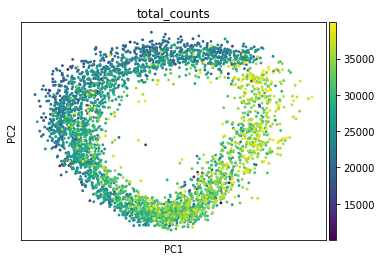

In [4]:
sc.tl.pca(sces,n_comps=30)
sc.pl.pca(sces,color='total_counts')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	67923.4754	4	4	4	0	0	0	45886.0861	42435.1524	0.6562	0.6821	3509.6359	18527.7535	74111.0139	296444.0557	0
0||5	54950.6257	5	5	5	0	0	0	35650.7977	31899.1673	0.7329	0.761	4067.7774	15232.0506	76160.2531	380801.2654	0
0||6	44235.9339	6	6	6	0	0	0	27908.3858	24037.9242	0.7909	0.8199	4409.1337	11918.4144	71510.4861	429062.9166	0
0||7	37981.1937	7	7	7	0	0	0	24190.5537	205

/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


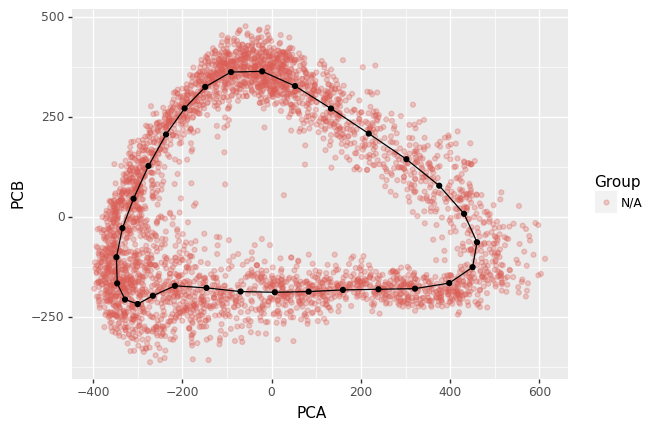

[<ggplot: (8785956553861)>]


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Normalizing by partition...
Re-running pooling...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	12698.121	30	30	30	0	0	0	8961.0764	8316.2006	0.9365	0.9411	2616.9157	1120.1288	33603.8644	1008115.933	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet impl

/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


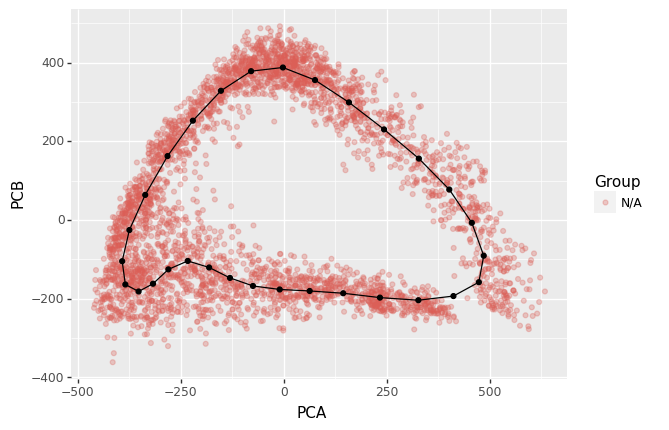

[<ggplot: (8785956469657)>]


In [5]:
#-- Re-normalize
sces30 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 30)
renormalize_by_partition(sces30, sces)

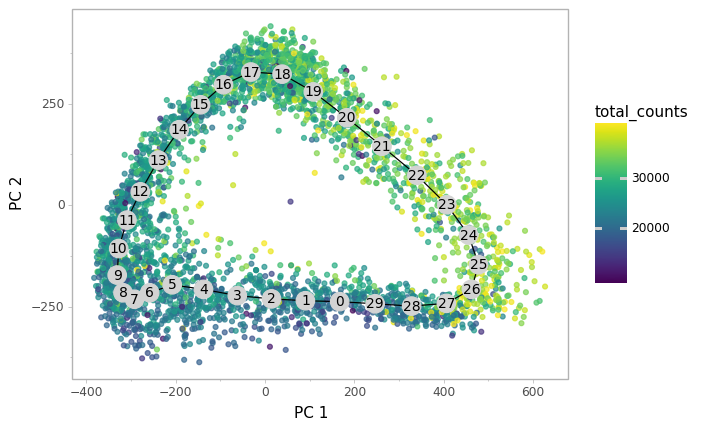

<ggplot: (8785956533233)>

In [6]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


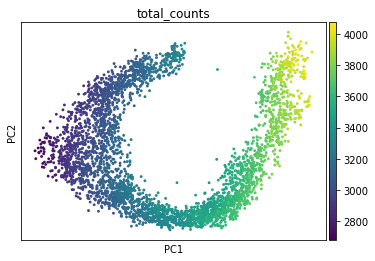

In [16]:
sc.tl.pca(sces30,n_comps=30)
sc.pl.pca(sces30,color='total_counts')

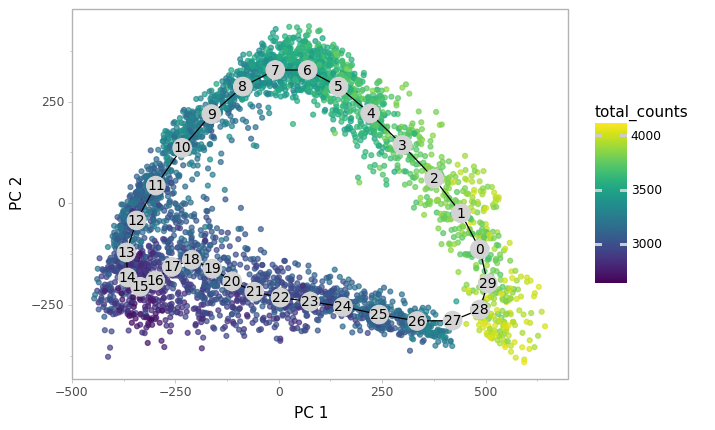

<ggplot: (8785956529649)>

In [14]:
#-- After renormalization
cc.pl.scatter_projection(sces30,trajectory = True)

### 10 partitions

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  10  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	67923.4754	4	4	4	0	0	0	45886.0861	42435.1524	0.6562	0.6821	3509.6359	18527.7535	74111.0139	296444.0557	0
0||5	54950.6257	5	5	5	0	0	0	35650.7977	31899.1673	0.7329	0.761	4067.7774	15232.0506	76160.2531	380801.2654	0
0||6	44235.9339	6	6	6	0	0	0	27908.3858	24037.9242	0.7909	0.8199	4409.1337	11918.4144	71510.4861	429062.9166	0
0||7	37981.1937	7	7	7	0	0	0	24190.5537	205

/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


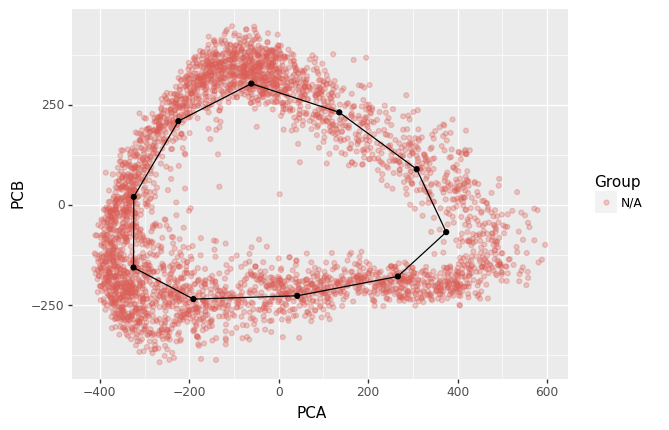

[<ggplot: (8785946261901)>]


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Normalizing by partition...
Re-running pooling...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  10  nodes on  3746  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||10	27335.3663	10	10	10	0	0	0	17618.3469	15014.6151	0.8737	0.8924	4391.499	5325.5203	53255.2032	532552.032	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.1783  seconds elapsed


/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


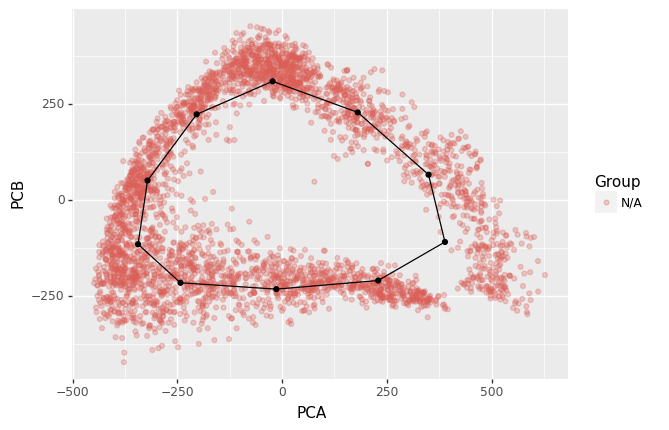

[<ggplot: (8785965129925)>]


In [9]:
#-- Re-normalize
sces10 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 10)
renormalize_by_partition(sces10, sces)

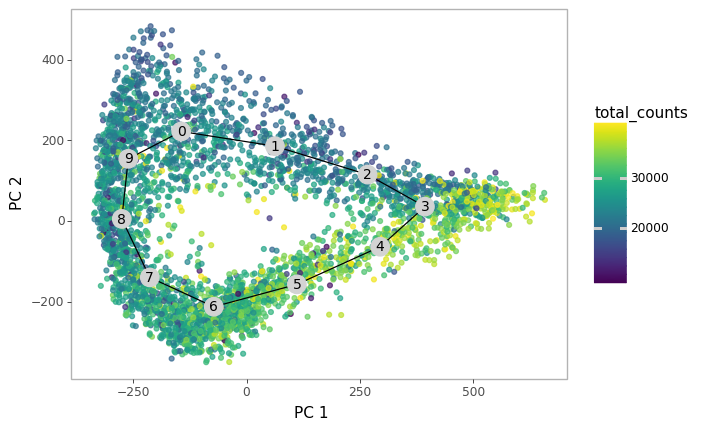

<ggplot: (8755963060201)>

In [8]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

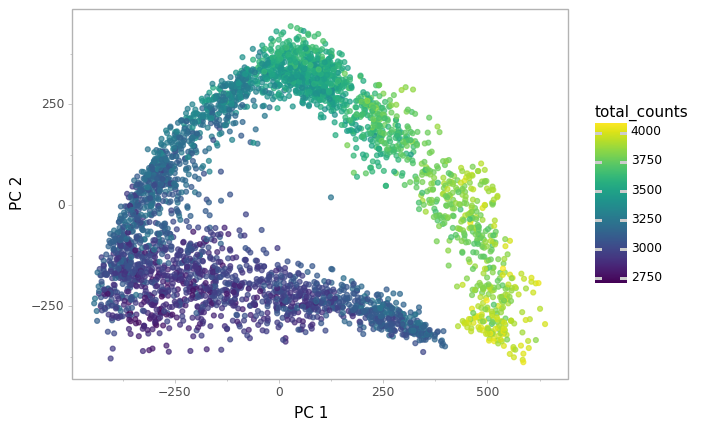

<ggplot: (8785962710517)>

In [10]:
#-- After renormalization
cc.pl.scatter_projection(sces10)

### 4 partitions

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  4  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	67923.4754	4	4	4	0	0	0	45886.0861	42435.1524	0.6562	0.6821	3509.6359	18527.7535	74111.0139	296444.0557	0
MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.0203  seconds elapsed


/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


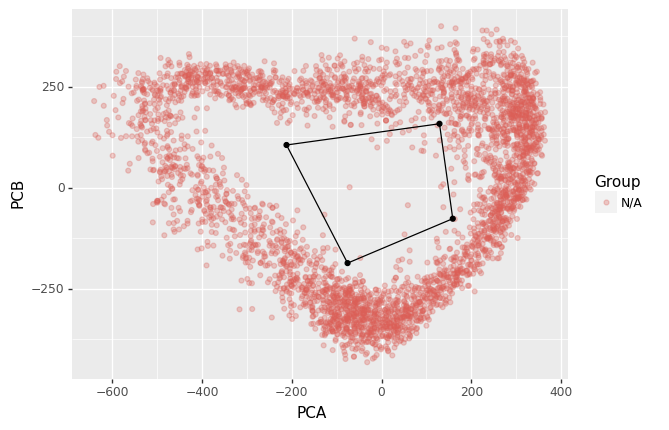

[<ggplot: (8785965100833)>]


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Normalizing by partition...
Re-running pooling...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/zinovyev/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  4  nodes on  3746  points and  4  dimensions
Nodes =  3 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	70132.1018	4	4	4	0	0	0	46163.9013	43315.2404	0.6743	0.6944	3828.8989	20139.3016	80557.2062	322228.8248	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
0.0242  seconds elapsed


/home/zinovyev/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


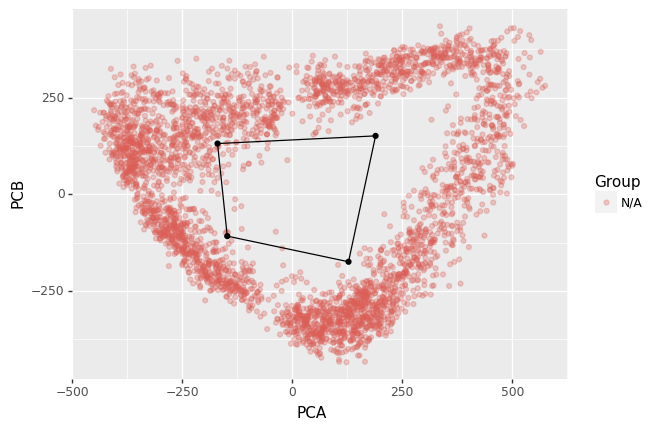

[<ggplot: (8785962658217)>]


In [11]:
#-- Re-normalize
sces4 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 4)
renormalize_by_partition(sces4, sces)

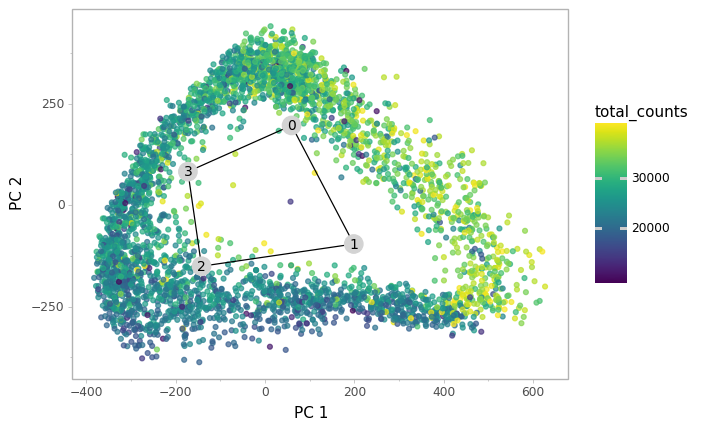

<ggplot: (8785965056653)>

In [12]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

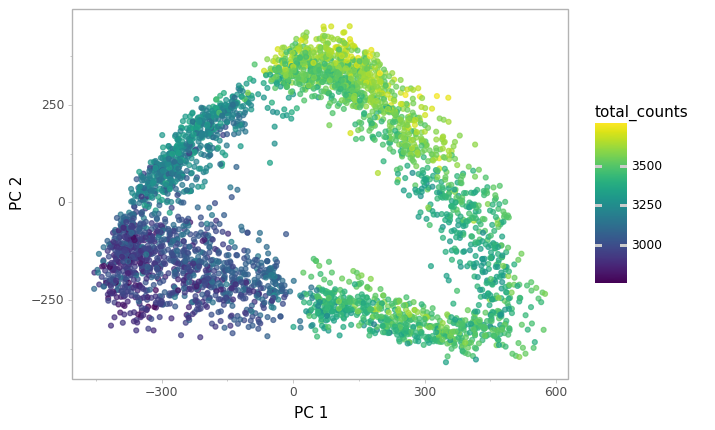

<ggplot: (8785965064549)>

In [13]:
#-- After renormalization
cc.pl.scatter_projection(sces4)